# Network and Vertex feature joint representation learning

In many network problems, we might have access to much more information than just the 
collection of nodes and edges in the network. If we were investigating a social 
network, for instance, we might have access to extra information about each 
person -- their gender, for instance, or their age. If we were investigating a brain network, we might have information about the physical location of neurons, or the volume of a brain region. When we we embed a network, it seems 
like we should be able to use these extra bits of information - called "features" or "covariates" - to somehow improve our analysis.
Many of the techniques and tools that we'll explore in this section use both the covariates and the network to 
learn from new, holistic representations of the data available to us. Because our new representations jointly using both the network and our extra covariate information, these techniques are called joint representation learning.

There are two primary reasons that we might want to explore using node covariates in addition to networks. First, they might improve our 
standard embedding algorithms, like Laplacian and Adjacency Spectral Embedding. 
For example, if the latent structure of the covariates lines up with the latent structure
of our network, then we could conceivably reduce noise, even if the communities in our network don't overlap perfectly with the communities in our covariates. Second,
figuring out what the clusters of an embedding actually mean can sometimes be difficult, and covariates create a natural structure in our network that we can explore. Covariate information in brain networks telling us where in the brain each node is, for instance, might let us better cluster our network by brain region.

In this section, we'll explore different ways to learn from our data when we have access to these covariates in addition to our network. We'll explore *Covariate-Assisted Spectral Embedding* (CASE), a variation on Spectral Embedding. In CASE, instead of embedding the adjacency matrix or one of the many versions of its Laplacian, we'll combine the Laplacian and our covariates into a new matrix and embed that.

The best way to illustrate how using covariates might help us is to use a model in which some of our community information is in the covariates and some is in our network. Using the Stochastic Block Model, we’ll create a simulation using three communities: the first and second community will be indistinguishable in the network itself, and the second and third community will be indistinguishable in our covariates. By combining the network and the covariates, we get a nice embedding that lets us find three distinct community clusters.

### Stochastic Block Model

Suppose we have a Stochastic Block Model that looks like this.

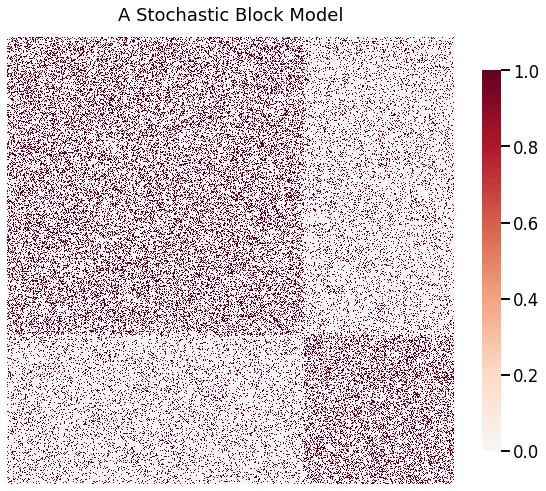

In [1]:
import warnings
warnings.filterwarnings("ignore")  # TODO: don't do this, fix scatterplot

import numpy as np
np.random.seed(42)

from graspologic.simulations import sbm
from graspologic.plot import heatmap

# Start with some simple parameters
N = 1500  # Total number of nodes
n = N // 3  # Nodes per community
p, q = .3, .15
B = np.array([[.3, .3, .15],
              [.3, .3, .15],
              [.15, .15, .3]])  # Our block probability matrix

# Make and visualize our Stochastic Block Model
A, labels = sbm([n, n, n], B, return_labels = True)
heatmap(A, title="A Stochastic Block Model");

There are three communities (we promise), but the first two are impossible to distinguish between using only our network. The third community is distinct: nodes belonging to it aren't likely to connect to nodes in the first two communities, and are very likely to connect to each other. If we wanted to embed this graph using our Laplacian or Adjacency Spectral Embedding methods, we'd find the first and second communities layered on top of each other.

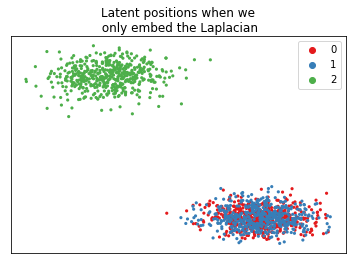

In [2]:
from graspologic.embed import LaplacianSpectralEmbed as LSE
from graspologic.utils import to_laplacian
import matplotlib.pyplot as plt
import seaborn as sns


def plot_latents(latent_positions, *, title, labels, ax=None):
    if ax is None:
        ax = plt.gca()
    plot = sns.scatterplot(latent_positions[:, 0], latent_positions[:, 1], hue=labels, 
                           palette="Set1", linewidth=0, s=10, ax=ax)
    plot.set_title(title, wrap=True);
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
    return plot

L = to_laplacian(A, form="R-DAD")
lse = LSE(form="R-DAD", n_components=2)
L_latents = lse.fit_transform(L)
plot_latents(L_latents, title="Latent positions when we\n only embed the Laplacian", 
             labels=labels);

We'd like to use extra information to more clearly distinguish between the first and second community. We don't have this information in our network: it needs to come from somewhere else.

### Covariates

But we're in luck - we have a set of covariates for each node! These covariates contain the extra information we need that allows us to separate our first and second community. However, with only these extra covariate features, we can no longer distinguish between the last two communities - they contain the same information.

Below is a visualization of our covariates. Remember, each node is associated with its own group of covariates that provide information about that node. We'll organize this information into a matrix, where the $i_{th}$ row contains the covariates associated with node $i$. For simplicity, the only values in this matrix will be 1 and 0.

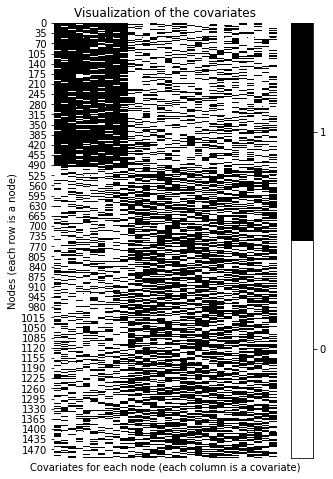

In [3]:
import numpy as np
from scipy.stats import bernoulli
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import normalize

def gen_covariates(p1=.9, p2=.6, p3=.3, N=1500):
    """
    Generate a matrix of covariates.
    """
    n_covariates = 30

    bern = lambda p: bernoulli.rvs(p, size=(N//3, n_covariates//3))    
    X = np.block([[bern(p1), bern(p3), bern(p3)],
                  [bern(p3), bern(p2), bern(p2)],
                  [bern(p3), bern(p2), bern(p2)]])

    return X

# Generate a covariate matrix
X = gen_covariates(N=N)

# Plot and make the axis look nice
fig, ax = plt.subplots(figsize=(5, 8))
colors = ["white", "black"]
cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))
ax = sns.heatmap(X, cmap=cmap, ax=ax)
ax.set(title="Visualization of the covariates", xticks=[], 
       ylabel="Nodes (each row is a node)",
       xlabel="Covariates for each node (each column is a covariate)");

# make the colorbar look nice
cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))
cbar = ax.collections[0].colorbar
cbar.set_ticks([0.25, 0.75])
cbar.set_ticklabels(['0', '1'])
cbar.ax.set_frame_on(True)

We can play almost the same game here as we did with the Laplacian. If we embed the information contained in this matrix of covariates into lower dimensions, we can see the reverse situation as before - the first community is separate, but the last two are overlayed on top of each other.

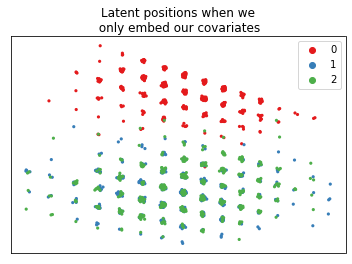

In [4]:
XXt = X@X.T
X_latents = lse.fit_transform(XXt)
plot_latents(X_latents, title="Latent positions when we\n only embed our covariates", 
             labels=labels);

We need a solution. This is where CASE comes in.

## Covariate-Assisted Spectral Embedding

<i>Covariate-Assisted Spectral Embedding</i>, or CASE<sup>1</sup>, is a simple way of combining our network and our covariates into a single model. In the most straightforward version of CASE, we combine the network's regularized Laplacian matrix $L$ and a function of our covariate matrix $XX^T$. Here, $X$ is just our covariate matrix, in which row $i$ contains the covariates associated with node $i$. Notice the word "regularized" - This means (from the Laplacian section earlier) that we are using $L = L_{\tau} = D_{\tau}^{-1/2} A D_{\tau}^{-1/2}$.

```{note}
Suppose that $X$ only contains 0's and 1's. To interpret $XX^T$, remember from linear algebra that we're taking the weighted sum - or, in math parlance, the dot product - of each row with each other row, as shown below (where each of these vectors represent rows of $X$):

\begin{align}
\begin{bmatrix}
1 \\
1 \\
1 \\
\end{bmatrix} \cdot 
\begin{bmatrix}
0 \\
1 \\
1 \\
\end{bmatrix} = 1\times 0 + 1\times 1 + 1\times 1 = 2
\end{align}

If there are two overlapping 1's in the same position of the left vector $i$ and the right vector $j$, then there will be an additional 1 added to their weighted sum. The resulting value, $XX^T_{i, j}$, will be equal to the number of shared locations in which vectors $i$ and $j$ both have ones.
```

A particular value in $XX^T$, $XX^T_{i, j}$, can be interpreted as measuring the "agreement" or "similarity" between row $i$ and row $j$ of our covariate matrix. The higher the value, the more the two rows share 1's in the same column. The result is a matrix that looks fairly similar to our Laplacian!  

The following Python code generates both our SBM and our covariate matrices. We'll also normalize the rows of our covariate matrix to have unit length using scikit-learn - this will be useful later.

In [5]:
import numpy as np
from graspologic.utils import to_laplacian
from graspologic.simulations import sbm
from sklearn.preprocessing import normalize

def gen_sbm(p=.3, q=.15, N=1500):
    """
    Generate an adjacency matrix.
    """
    n = N // 3
    B = np.full((3, 3), q)
    B[np.diag_indices_from(B)] = p
    A = sbm([n, n, n], B, return_labels=True)

    return A
    
def gen_covariates(m1=.9, m2=.6, m3=.3, N=1500):
    """
    Generate a matrix of covariates.
    """
    n_covariates = 30

    # Make a function that draws covariates from a Bernoulli distribution
    bern = lambda p: bernoulli.rvs(p, size=(N//3, n_covariates//3))    
    X = np.block([[bern(m1), bern(m3), bern(m3)],
                  [bern(m3), bern(m2), bern(m2)],
                  [bern(m3), bern(m2), bern(m2)]])

    return X

# Generate a covariate matrix
X = gen_covariates(N=N)
X = normalize(X, axis=0)

L = to_laplacian(A, form="R-DAD")
XXt = X@X.T

You can see what our two matrices look like below. As you can see, each matrix contains information about our communities that the other doesn't have.

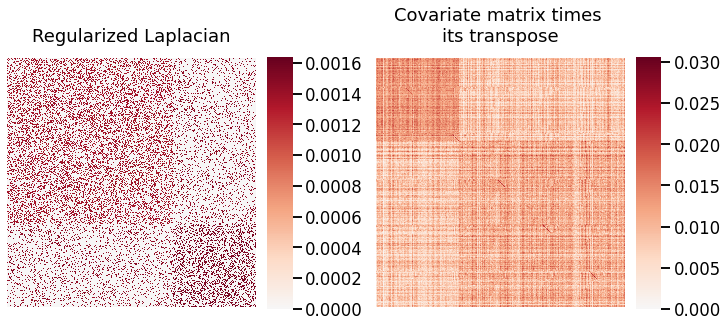

In [6]:
# plot
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5), constrained_layout=True)
L_ax = heatmap(L, title=r"Regularized Laplacian", ax=axs[0])
X_ax = heatmap(XXt, title="Covariate matrix times \nits transpose", ax=axs[1]);

CASE simply sums these two matrices together, using a weight for $XX^T$ so that they both contribute an equal amount of useful information to the result. Here, we'll just use the ratio of the leading eigenvalues of our two matrices as our weight (henceforth known as $\alpha$). Later on, we'll explore ways to pick a better $\alpha$.

In [7]:
# Find the eigenvalues of L and XX^T (in ascending order)
L_eigvals = np.linalg.eigvalsh(L)
XXt_eigvals = np.linalg.eigvalsh(XXt)

# Find our simple weight - the ratio of the leading eigenvalues of L and XX^T.
alpha = np.float(L_eigvals[-1] / XXt_eigvals[-1])

# Using our simple weight, combine our two matrices
L_ = L + alpha * X@X.T

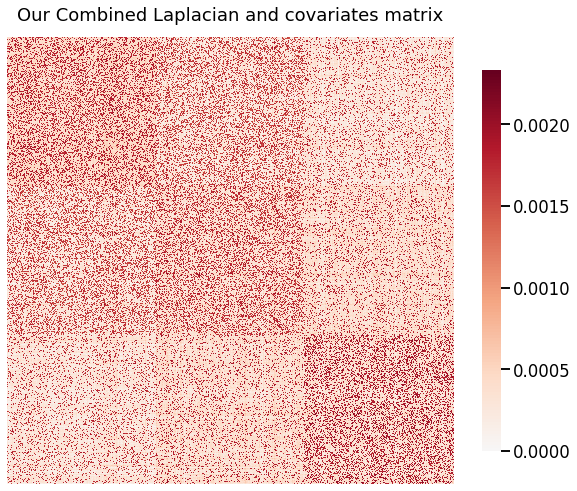

In [8]:
heatmap(L_, title="Our Combined Laplacian and covariates matrix");

As you can see, the combined matrix has some separation between all three groups. Because we used an imperfect weight, the Laplacian is clearly contributing more to the sum -- but it's good enough for now.

Now we can embed this network and see what the results look like. Our embedding works the same as it does in Laplacian Spectral Embedding from here: we decompose our combined matrix using an SVD, truncating the columns, and then we visualize the rows of the result. We'll embed all the way down to two dimensions, just to make visualization simpler.

In [9]:
from graspologic.embed import selectSVD
from graspologic.plot import pairplot
import scipy


def embed(A, *, dimension):
    latents, _, _ = scipy.linalg.svd(A)
    latents = latents[:, :dimension]
    return latents

latents_ = embed(L_, dimension=2)

Below, you can see three figures: the first is our embedding when we only use our network, the second is our embedding when we only use our covariates, and the third is our embedding when we only use both. We've managed to achieve separation between all three communities.

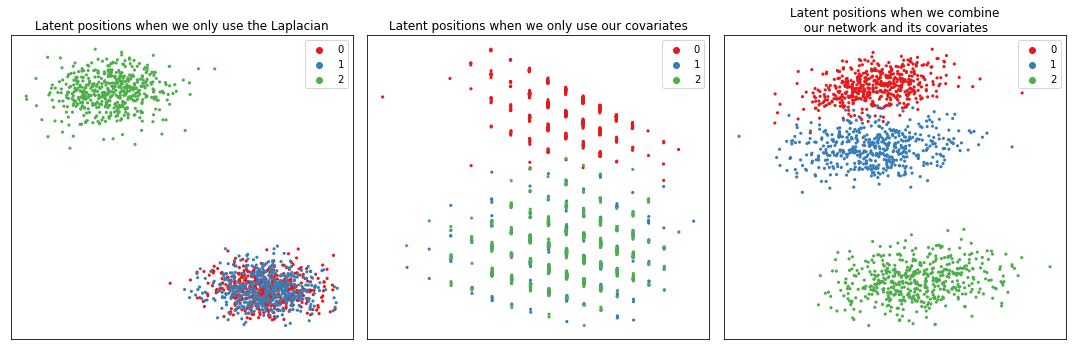

In [10]:
from graspologic.embed import LaplacianSpectralEmbed as LSE
    

X_latents = lse.fit_transform(XXt)

# Plot
fig, axs = plt.subplots(1, 3, figsize=(15,5))
plot_latents(L_latents, title="Latent positions when we only use the Laplacian", 
             labels=labels, ax=axs[0])
plot_latents(X_latents, title="Latent positions when we only use our covariates", 
             labels=labels, ax=axs[1]);
plot_latents(latents_, title="Latent positions when we combine\n our network and its covariates", 
             labels=labels, ax=axs[2])

plt.tight_layout()

### Setting A Better Weight

Our simple choice of the ratio of leading eigenvalues for our weight $\alpha$ is straightforward, but we can probably do better. If our covariate matrix doesn't tell us much about our communities, then we'd want to give it a smaller weight so we use more of the information in our Laplacian when we embed. If our Laplacian is similarly uninformative, we'd like a larger weight to emphasize the covariates.

In general, we'd simply like to embed in a way that makes our clustering better - meaning, if we label our communities, we'd like to be able to correctly retrieve as many labels after the embedding as possible with a clustering algorithm, and for our clusters to be as distinct as possible.

One reasonable way of accomplishing this goal is to simply find a range of possible $\alpha$ values, embed our combined matrix for every value in this range, and then to simply check which values produce the best clustering.

#### Getting A Good Range

For somewhat complicated linear algebra reasons<sup>1</sup>, it's fairly straightforward to get a good range of possible $\alpha$ values: a good minimum and maximum is described by only two equations. In the below equations, $K$ is the number of communities present in our network, $R$ is the number of covariate values each node has, and $\lambda_i(L)$ is the $i_{th}$ eigenvalue of L (where $\lambda_1(L)$ is our Laplacian's highest, or "leading", eigenvalue).

```{admonition} Equations for getting our $\alpha$ range
$\alpha_{min} = \frac{\lambda_K(L) - \lambda_{K+1}(L)}{\lambda_1(XX^T)}$

If the number of covariate dimensions is less than or equal to the number of clusters, then  
$\alpha_{max} = \frac{\lambda_1 (L)}{\lambda_R (XX^T)}$

Otherwise, if the number of covariate dimensions is greater than the number of clusters, then  
$\alpha_{max} = \frac{\lambda_1(L)}{\lambda_K(XX^T) -\lambda_{K+1} (XX^T)}$
```

In [11]:
from scipy.linalg import eigvalsh
from myst_nb import glue

def get_eigvals(M, n_eigvals):
    N = M.shape[0]
    top_eigvals = eigvalsh(M, subset_by_index=[N-n_eigvals, N-1])
    return np.flip(top_eigvals)

X_eigvals = get_eigvals(XXt, n_eigvals=4)
L_eigvals = get_eigvals(L, n_eigvals=4)
n_covariates = X.shape[1]
n_components = 3

amin = (L_eigvals[n_components - 1] - L_eigvals[n_components]) / X_eigvals[0]
if n_covariates > n_components:
    amax = L_eigvals[0] / (
        X_eigvals[n_components - 1] - X_eigvals[n_components]
    )
else:
    amax = L_top / X_eigvals[n_covariates - 1]
    
glue("amin", amin, display=False)
glue("amax", amax, display=False)

4.2359312775571826e-05

40.00562586174932

Using these equations, we get a minimum weight of {glue:}`amin` and a maximum weight of {glue:}`amax`.

#### Searching with K-Means

We have a range of possible weights to search through, but we don't have the best one. To find it, we'll embed with Covariate-Assisted Clustering, using all the tricks described previously, for as many alpha-values in our range as we're willing to test. Then, we'll simply pick the value which best lets us distinguish between the different communities in our network. 

To figure out which $\alpha$ is best, we need to cluster our data using a machine learning algorithm. The algorithm of choice will be scikit-learn's faster implementation of k-means. K-means is a simple algorithm capable of clustering most datasets very quickly and efficiently, often in only a few iterations. It works by initially sticking some number of predetermined cluster centers in essentially random places in our data, and then iterating through a searching procedure until all the cluster centers are in nice places. If you want more information, you can check out the original paper by Stuart Lloyd<sup>2</sup>, or scikit-learn's tutorial describing K-means<sup>3</sup>.

We also need to define exactly what it means to check which values produce the best clustering. Fortunately, K-means comes out-of-the-box with a fine definition: its objective function, the sum of squared distances of each point from its cluster center. In KMeans, this is called the "inertia".

Below is Python code which searches through our range of possible $\alpha$ values, and then tests a clustering using each value. Because it's quicker, we'll only look through ten values, but in principle the more values you test the better (and the slower).

4.235931277557181e-05: 0.017149083444858545


0.00019536957141698985: 0.017126149668054324


0.0009010833022217993: 0.017044913788664812


0.004155975322328694: 0.017294208713800992


0.019168184381196746: 0.027389678814754834


0.08840747693989694: 0.08186263117598762


0.40775285877078155: 0.08600743004374037


1.8806372446165007: 0.09025788904156264


8.673872836847387: 0.09136419645543331


40.005625861749316: 0.09161704113449845
Our best alpha-value is 0.00090108 with inertia 0.017044913788664812


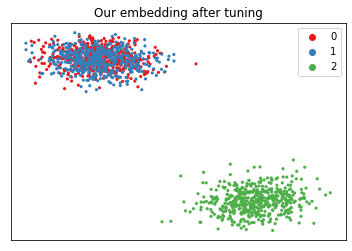

In [12]:
from sklearn.cluster import KMeans
    
# Assume we've already generated alphas using the 
# equations above
tuning_range = np.geomspace(amin, amax, num=10)
alphas = {}
for alpha in tuning_range:
    L_ = L + alpha*XXt
    latents = embed(L_, dimension=2)
    kmeans = KMeans(n_clusters=3).fit(latents)
    inertia = kmeans.inertia_
    alphas[alpha] = inertia
    print(f"{alpha}: {inertia}")

best_alpha = min(alphas, key=alphas.get)
print(f"Our best alpha-value is {best_alpha:0.8f} with inertia {alphas[best_alpha]}")

new_latents = embed(L+best_alpha*XXt, dimension=2)
plot_latents(new_latents, title="Our embedding after tuning", labels=labels);

Tuning the weight noticeably improved our clustering. Below, you can see the difference between our embedding prior to tuning and our embedding after tuning.

<AxesSubplot:title={'center':'Our embedding after tuning'}>

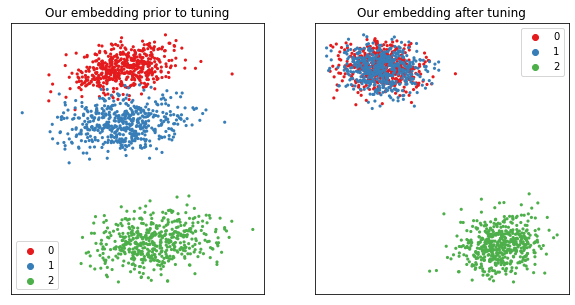

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
plot_latents(latents_, title="Our embedding prior to tuning", labels=labels, ax=axs[0])
plot_latents(new_latents, title="Our embedding after tuning", labels=labels, ax=axs[1])

### Variations on CASE

There are situations where changing the matrix that you embed is useful. 

*non-assortative*  
If your graph is *non-assortative* - meaning, the between-block probabilities are greater than the within-block communities - it's better to square your Laplacian. You end up embedding $LL + aXX^T$.  

*big graphs*  
Since the tuning procedure is computationally expensive, you wouldn't want to spend the time tuning $\alpha$ for larger graphs. There are a few options here: you can use a non-tuned version of alpha, or you can use a variant on classical correlation analysis<sup>4</sup> and simply embed $LX$.

### Using Graspologic

Graspologic's CovariateAssistedSpectralEmbedding class uses SVD decomposition to implement CASE, just like we just did earlier. The following code applies CASE to reduce the dimensionality of $L + aXX^T$ down to three dimensions, and then plots the second dimension against the third to show the clustering. You can also try the above variations on CASE with the `embedding_alg` parameter.

In [14]:
from graspologic.embed import CovariateAssistedEmbedding as CASE

casc = CASE(embedding_alg="assortative", n_components=3)
latents = casc.fit_transform(A, covariates=X)
plot_latents(latents, title="Embedding our model using graspologic", labels=labels)

inertia at 15.28080: 0.70969


inertia at 24.72484: 0.70978


inertia at 9.44406: 0.70956


inertia at 5.83676: 0.70932


inertia at 3.60732: 0.70897


inertia at 2.22945: 0.70832


inertia at 1.37789: 0.70729


inertia at 0.85159: 0.70563


inertia at 0.52632: 0.70282


inertia at 0.32529: 0.69900


inertia at 0.20105: 0.47159


inertia at 0.12426: 0.26147


inertia at 0.07680: 0.24805


inertia at 0.09337: 0.24852


inertia at 0.08336: 0.24767


inertia at 0.08342: 0.24767


inertia at 0.08319: 0.24767


inertia at 0.08319: 0.24767


inertia at 0.08319: 0.24767


inertia at 0.08318: 0.24767

Maximum number of function evaluations exceeded --- increase maxfun argument.



TypeError: unsupported operand type(s) for *: 'OptimizeResult' and 'float'

#### References

[1] N. Binkiewicz, J. T. Vogelstein, K. Rohe, Covariate-assisted spectral clustering, Biometrika, Volume 104, Issue 2, June 2017, Pages 361–377, https://doi.org/10.1093/biomet/asx008  
[2] Lloyd, S. (1982). Least squares quantization in PCM. IEEE transactions on information theory, 28(2), 129-137.  
[3] https://scikit-learn.org/stable/modules/clustering.html#k-means
[4] Hotelling, H. (1936). Relations between two sets of variates. Biometrika 28, 321–77.